# BERT Baseline - Cross-Prompt AES

Treinamento rápido (2 épocas) do modelo BERT baseline para demonstração.

**Configuração**: Treinar em prompts [1,3,4,5,6,7,8] → Testar em prompt 2

## Importar bibliotecas

In [1]:
import sys
sys.path.append('..')

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import AutoTokenizer
import numpy as np
from tqdm import tqdm

from src.data.dataset import ASAPDataset
from src.data.tokenizer import EssayTokenizer
from src.models.transformer_aes import BertAES
from src.evaluation.metrics import compute_qwk, compute_correlations

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


## Carregar e preparar dados

In [2]:
data_path = '../data/raw/training_set_rel3.tsv'
dataset = ASAPDataset(data_path)
df = dataset.load_data()

test_prompt = 2
train_prompts = [1, 3, 4, 5, 6, 7, 8]

train_df = df[df['essay_set'].isin(train_prompts)].copy()
test_df = df[df['essay_set'] == test_prompt].copy()

train_df['normalized_score'] = train_df.apply(
    lambda row: dataset.normalize_score(row['domain1_score'], row['essay_set']),
    axis=1
)
test_df['normalized_score'] = test_df.apply(
    lambda row: dataset.normalize_score(row['domain1_score'], row['essay_set']),
    axis=1
)

print(f"Train: {len(train_df)} essays")
print(f"Test: {len(test_df)} essays")

Loading ASAP dataset from ../data/raw/training_set_rel3.tsv
Loaded 12976 essays across 8 prompts
Train: 11176 essays
Test: 1800 essays


## Tokenização

In [3]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
essay_tokenizer = EssayTokenizer(tokenizer, max_length=512)

train_dataset = essay_tokenizer.tokenize_dataset(
    train_df['essay'].tolist(),
    train_df['normalized_score'].tolist()
)
test_dataset = essay_tokenizer.tokenize_dataset(
    test_df['essay'].tolist(),
    test_df['normalized_score'].tolist()
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

print(f"Train batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

Train batches: 699
Test batches: 113


## Inicializar modelo BERT

In [4]:
model = BertAES('bert-base-uncased').to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.MSELoss()

total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")

Loading transformer model: bert-base-uncased
Total parameters: 109,483,009


## Função de treinamento por época

In [5]:
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    
    pbar = tqdm(loader, desc='Training')
    for batch in pbar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs['predictions'], labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    return total_loss / len(loader)

## Função de avaliação

In [6]:
def evaluate(model, loader, device):
    model.eval()
    predictions = []
    targets = []
    
    with torch.no_grad():
        for batch in tqdm(loader, desc='Evaluating'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask)
            
            predictions.extend(outputs['predictions'].cpu().numpy().tolist())
            targets.extend(labels.cpu().numpy().tolist())
    
    return np.array(predictions), np.array(targets)

## Treinamento (2 épocas)

In [7]:
num_epochs = 2
history = {'train_loss': [], 'test_qwk': []}

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    print("-" * 70)
    
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    history['train_loss'].append(train_loss)
    
    preds, targets = evaluate(model, test_loader, device)
    
    min_score, max_score = dataset.SCORE_RANGES[test_prompt]
    preds_denorm = preds * (max_score - min_score) + min_score
    targets_denorm = targets * (max_score - min_score) + min_score
    preds_denorm = np.round(np.clip(preds_denorm, min_score, max_score))
    
    qwk = compute_qwk(targets_denorm, preds_denorm, min_score, max_score)
    history['test_qwk'].append(qwk)
    
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Test QWK: {qwk:.4f}")


Epoch 1/2
----------------------------------------------------------------------


Evaluating: 100%|██████████| 113/113 [00:12<00:00,  9.12it/s]


Train Loss: 0.0246
Test QWK: 0.3051

Epoch 2/2
----------------------------------------------------------------------


Evaluating: 100%|██████████| 113/113 [00:15<00:00,  7.49it/s]

Train Loss: 0.0168
Test QWK: 0.4523


## Avaliação final completa

In [8]:
preds, targets = evaluate(model, test_loader, device)

min_score, max_score = dataset.SCORE_RANGES[test_prompt]
preds_denorm = preds * (max_score - min_score) + min_score
targets_denorm = targets * (max_score - min_score) + min_score
preds_denorm = np.round(np.clip(preds_denorm, min_score, max_score))

qwk = compute_qwk(targets_denorm, preds_denorm, min_score, max_score)
correlations = compute_correlations(targets_denorm, preds_denorm)

print("\n" + "="*70)
print("Final Test Results - BERT Baseline")
print("="*70)
print(f"QWK: {qwk:.4f}")
print(f"Pearson: {correlations['pearson']:.4f}")
print(f"Spearman: {correlations['spearman']:.4f}")
print("="*70)

Evaluating: 100%|██████████| 113/113 [00:12<00:00,  9.00it/s]


Final Test Results - BERT Baseline
QWK: 0.4523
Pearson: 0.6735
Spearman: 0.6427


## Visualizar curva de aprendizado

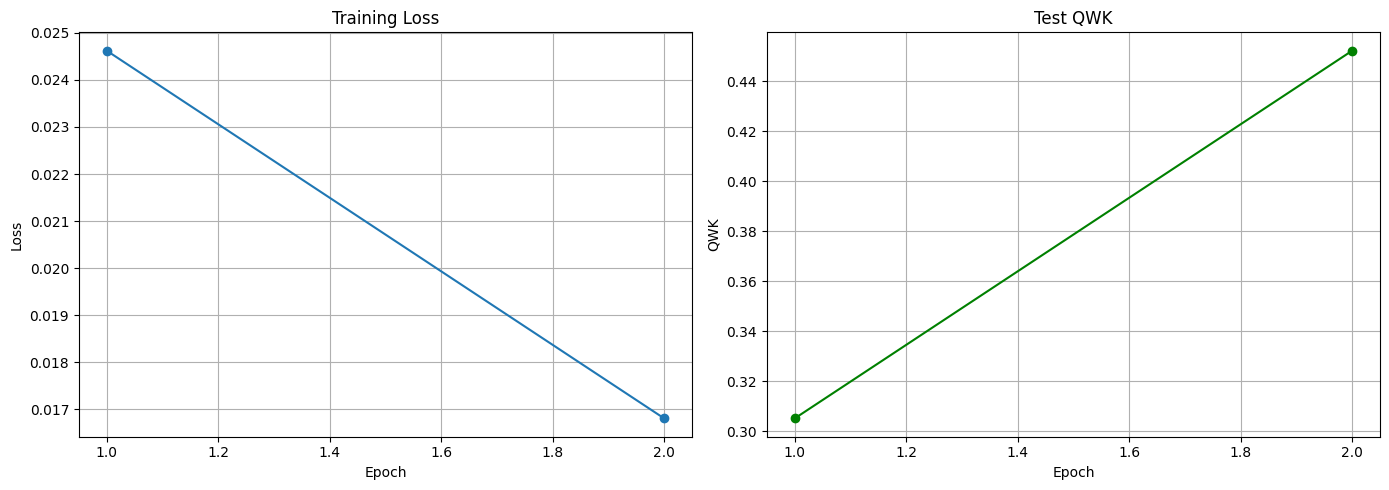

In [9]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(range(1, num_epochs + 1), history['train_loss'], marker='o')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss')
axes[0].grid(True)

axes[1].plot(range(1, num_epochs + 1), history['test_qwk'], marker='o', color='green')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('QWK')
axes[1].set_title('Test QWK')
axes[1].grid(True)

plt.tight_layout()
plt.show()

## Distribuição de predições vs targets

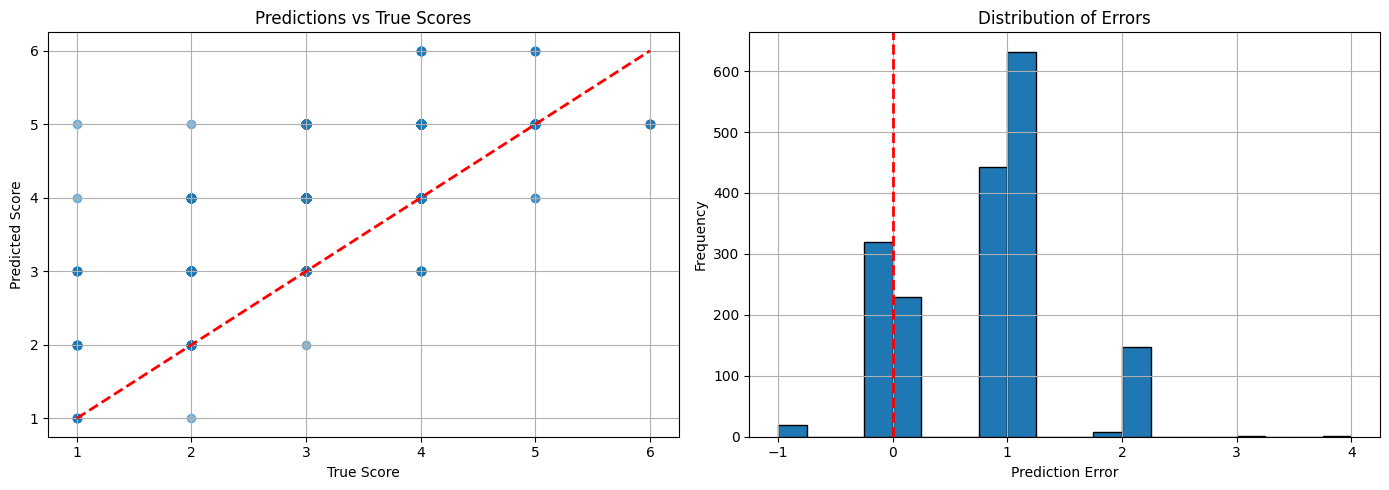

In [10]:
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(targets_denorm, preds_denorm, alpha=0.5)
axes[0].plot([min_score, max_score], [min_score, max_score], 'r--', lw=2)
axes[0].set_xlabel('True Score')
axes[0].set_ylabel('Predicted Score')
axes[0].set_title('Predictions vs True Scores')
axes[0].grid(True)

errors = preds_denorm - targets_denorm
axes[1].hist(errors, bins=20, edgecolor='black')
axes[1].set_xlabel('Prediction Error')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Errors')
axes[1].axvline(0, color='r', linestyle='--', lw=2)
axes[1].grid(True)

plt.tight_layout()
plt.show()

## Salvar modelo

In [11]:
import json
from pathlib import Path

output_dir = Path('../checkpoints/bert_demo')
output_dir.mkdir(parents=True, exist_ok=True)

torch.save(model.state_dict(), output_dir / 'model.pt')

results = {
    'test_prompt': test_prompt,
    'train_prompts': train_prompts,
    'epochs': num_epochs,
    'qwk': float(qwk),
    'pearson': float(correlations['pearson']),
    'spearman': float(correlations['spearman'])
}

with open(output_dir / 'results.json', 'w') as f:
    json.dump(results, f, indent=2)

print(f"Model saved to {output_dir}")

Model saved to ../checkpoints/bert_demo
